## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


4. Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

### 1. 

И User-User и Item-Item это методики основанные на коллаборативной фильтрации. Сходство их в том, что они используют матрицу интеракций для поиска сходных элементов и на основе этого сходства делают рекомендации (пользователям рекомендуются товары понравившиеся другим пользователям схожим с целевым (user-user), или наоборот - пользователям рекомендуются товары, схожие с товарами, которые пользователь уже купил (item-item)). По сути это один и тот-же метод - просто работающий на по-разному представленных данных. Item-Item rec превращается в User-User rec путем простого транспонирования исходной матрицы интеракций. 

Оба метода обладают сравнимой мощностью, однако пишут, что Item-Item предпочтителен на исходных выборках меньшего масштаба, а User-User оказывается впереди на более крупных наборах данных. Источник https://www.diva-portal.org/smash/get/diva2:1111865/FULLTEXT01.pdf

Принципиальное отличие от ALS наверное в том, что в ALS (хотя тоже является collaborative filtering методом), вычисления не основываются на критерии близости чего-то к чему-то. Сходство в ALS вычисляется, посредством настройки латентных параметров юзеров и товаров с помощью градиентного спуска. В итоге получаются две матрицы которые при перемножении дают исходную полную матрицу интеракций для всех пользователей (в том числе и для тех, интеракции, для которых еще не были известны, для которых нужно сделать рекомендации).. Как-то немного сумбурно, по ощущениям ))

### 2.

1. Количество переходов пользователем на страницу товара (было на вебинаре - но тк я предлагал - использую это :)
2. Время проведенное на странице товара (всё же измеряется сейчас)
3. Как-то ранжировать источник перехода.. Можно наверное предположить зависимость степени интереса пользователя к товару от того как он попал на страницу. Например organic search - максимальный (искал именно это), а из рекомендательного блока "также посмотрите" - ну наверное наименее целевой заход (из любопытства).. возможно немного притянуто за уши, но теоретически можно подумать о таком ранге..

### 3.

Что-то затрудняюсь сказать.. кроме того, что он для implicit данных, ничего в голову не приходит. Но, зная что имплисит можно легко получить из эксплисит данных - так себе ограничение ))

### 4.

## Практическая часть


In [2]:
import implicit

In [75]:
# import data
# utils functions like in webinar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

data = pd.read_csv('retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [6]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [7]:
# Так, ну для начала по комментам к прошлому ДЗ немного "причешем" датасет

In [43]:
# Разбираемся с супер-популярным бензином
items = data_train.groupby('item_id')['quantity'].sum().reset_index()
items.columns = ('item_id', 'sales_sum')
items.loc[(items.sales_sum > 10000000)].item_id.tolist()

[6533889, 6534166, 6534178]

In [18]:
# Проверяем сколько пользователей реально это покупало..
data_train.loc[data_train['item_id'].isin((6534178, 6534166, 6533889))].groupby('user_id')['quantity'].sum()

user_id
3          6949
6         92298
8         65912
13      1153674
14       117162
         ...   
2496     119016
2497       4675
2498      13142
2499     141907
2500     224230
Name: quantity, Length: 1331, dtype: int64

In [ ]:
# Хмм. довольно много народу - получается реально такой "ходовой товар". 
# Идея выкинуть его из рекомендаций меня все же не покидает. Но тут вопрос - вот мы его поместим в filtered и
# И допустим улучшим качество реальных рекомендаций, скажем по причине его популярности, "его и так купят"
# А это ухудшит нам метрику (поскольку в тестовых данных люди его покупали - а мы его не рекомендуем)
# Вот это меня беспокоит - мы же разрабатывая модель будем на метрику ориентироваться в первую очередь. 
# И в здравом уме не выберем вариант, где эта метрика - хуже.
# Как в метрику закладываются такие "супер-популярные" товары - которые "и так купят"?
# Или при расчете метрики - нам его нужно и из actual убирать? (и следить, чтобы actual не стал меньше K)

In [39]:
# Начнем набирать список для filtered
super_benzines = items.loc[(items.sales_sum > 10000000)].item_id.tolist()

In [28]:
# Далее, самые дешевые, самые дорогие, самые популярные и тп
data_train['price'] = data_train['sales_value']/data_train['quantity']
data_train.price.quantile(0.2)

<ipython-input-28-90ab88bf97cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['price'] = data_train['sales_value']/data_train['quantity']


0.99

In [34]:
data_train.price.quantile(0.99994)

99.99

In [71]:
# Функция которая сформирует списки на исключение из рекомендаций
# По опыту предыдущего ДЗ предполагаю, что исключать позиции из рекомендаций можно только подавая их список в filter
# Либо, если мы хотим исключить эти товары вообще из модели и из расчетов - то мы должны их заменить каким-то
# Единым dummy идентификатором. Исключать из трейна строки с этими товарами черевато потерей пользователей в трейне
# Что может привести к фейлу алгоритма на этапе предсказания

def get_filter(data):
    """Функция получения списка для фильтрации на этапе recommend"""
    # Уберем самые популярные товары (их и так купят)
    popularity = data.groupby('item_id')['user_id'].nunique().reset_index()
    popularity['user_id'] = popularity['user_id'] / data_train['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    
    cheapest = data.loc[data.price < data.price.quantile(0.2)].item_id.tolist()
    expensive = data.loc[data.price > data.price.quantile(0.99994)].item_id.tolist()
    
    sales = data.groupby('item_id')['quantity'].sum().reset_index()
    sales.columns = ('item_id', 'sales_sum')
    top_sales = sales.loc[(items.sales_sum > 10000000)].item_id.tolist()
    
    return top_popular + top_notpopular + cheapest + expensive + top_sales

In [74]:
to_filter = list(set(get_filter(data_train)))
len(to_filter)

78827

In [77]:
# Тестовые таргеты для получения метрик
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [78]:
# Попробуем на полном наборе позиций для начала (может быть хватит сил)

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', 
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) 
sparse_user_item = csr_matrix(user_item_matrix).tocsr()
user_item_matrix.head(3)

item_id,25671,26081,26093,26190,26355,26426,26540,26601,26636,26691,...,17328742,17329473,17329749,17330255,17330511,17381856,17382205,17383227,17827644,17829232
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
user_item_matrix.shape

(2499, 86865)

In [325]:
model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),
          show_progress=True)

In [80]:
userids = user_item_matrix.index.values
matrix_userids = np.arange(len(userids))
userid_to_id = dict(zip(userids, matrix_userids))

In [87]:
def get_recommendations(user, matrix, model, N=5, items_to_filter=None):
    res = [matrix.columns.values[rec[0]] for rec in
                    model.recommend(userid=user, 
                                    user_items=csr_matrix(matrix).tocsr(), 
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=items_to_filter, 
                                    recalculate_user=True)]
    return res

In [92]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(userid_to_id[x], matrix=user_item_matrix, model=model))
# result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
result.head(3)

CPU times: user 278 µs, sys: 25 µs, total: 303 µs
Wall time: 290 µs


,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 901062, 9527290, 1051211, 979707]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 1133018, 951590, 938700, 5568378]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[878996, 834484, 908846, 1051516, 866211]"


In [94]:
# Эх.. все упало. precision_at_k из implicit - это не то, что я думал - 
# и мы не узнаем сколько времени длилось вычисление рекомендаций - но примерно не меньше 4 часов.
# А если попробовать recommend_all (может это pandas так страшно тупит?)

In [326]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=csr_matrix(user_item_matrix).tocsr(),
                                      filter_already_liked_items=True, 
                                      filter_items=None, 
                                      recalculate_user=True,
                                      show_progress=True,
                                      batch_size=500)


CPU times: user 48.8 s, sys: 1.55 s, total: 50.4 s
Wall time: 49.5 s


In [332]:
recommendations

array([[36745, 36938, 28653, 39619, 31270],
       [25064, 23590, 28895, 55470, 15011],
       [15513, 17915, 10029, 34498, 26161],
       ...,
       [55470, 25064, 23590, 36454, 34595],
       [29848, 10837,  7933, 51478, 27079],
       [10029, 16139, 16343, 26284, 37343]], dtype=int32)

In [343]:
# Похоже на то, кстати..
# Надо сохранить их в result тоже
result['als_all'] = result['user_id'].apply(
    lambda x: [user_item_matrix.columns.values[rec] for rec in recommendations[userid_to_id[x]]])

In [ ]:
# Узнаем какой получился скор

def precision_at_k(recommended, actual, k=5):
    flags = np.isin(recommended[:k], actual)
    return flags.sum() / len(recommended[:k])

v_precision_at_k = np.vectorize(precision_at_k)

In [96]:
v_precision_at_k(result.als, result.actual).mean()

0.1859941234084231

In [344]:
v_precision_at_k(result.als_all, result.actual).mean()

0.034965719882468174

In [102]:
# Из recommend_all - чушь какая-то.. Или я не смог правильно все сделать...
# А наш - супермедленный метод дает не самый плохой кстати скор. (вспоминая бэйзлайны с прошлого ДЗ по крайней мере)
# Но адски долго. В этом свете интересен момент получения быстрых предсказаний
model.item_factors.shape

(86865, 100)

In [103]:
model.user_factors.shape

(2499, 100)

In [107]:
%%time
fast_recs = model.user_factors @ model.item_factors.T
fast_recs.shape

CPU times: user 975 ms, sys: 421 ms, total: 1.4 s
Wall time: 851 ms


(2499, 86865)

In [137]:
# И что нам теперь делать с этой матрицей? Выбирать 5 наибольших рейтингов из строки пользователя 
# получить item_id от этих колонок и ставить товары в рекомендации?

def to_item_id(idx):
    return user_item_matrix.columns.values[idx]

v_to_item_id = np.vectorize(to_item_id)

In [138]:
%%time
result['fast_als'] = result['user_id'].apply(lambda x: v_to_item_id(np.argsort(fast_recs[userid_to_id[x]])[-5:]))

CPU times: user 13.4 s, sys: 55.8 ms, total: 13.5 s
Wall time: 13.6 s


In [139]:
result.head(2)

,user_id,actual,als,fast_als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 901062, 9527290, 1051211, 979707]","[979707, 995242, 9527290, 901062, 1033142]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 1133018, 951590, 938700, 5568378]","[883404, 938700, 951590, 1133018, 1106523]"


In [140]:
# Быстро. Какой будет скор?
v_precision_at_k(result.fast_als, result.actual).mean()

0.1851126346718903

In [ ]:
# Нууууу... он лишь чуть чуть хуже чем при 4 часовых вычислениях..  в десятитысячных - различия
# Тогда пока считаю что мы спасены. Можем дальше развлекаться на полном датасете

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [141]:
# TFIDF
user_item_matrix_tfidf = tfidf_weight(user_item_matrix.T).T

In [147]:
%%time
model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix_tfidf).T.tocsr(),
          show_progress=True)


CPU times: user 23.6 s, sys: 1.12 s, total: 24.7 s
Wall time: 16.8 s


In [148]:
%%time
fast_tfidf_recs = model.user_factors @ model.item_factors.T

CPU times: user 931 ms, sys: 453 ms, total: 1.38 s
Wall time: 1.45 s


In [156]:
%%time
result['fast_als_tfidf'] = result['user_id'].apply(lambda x: v_to_item_id(np.argsort(fast_tfidf_recs[userid_to_id[x]])[-5:]))

CPU times: user 13.4 s, sys: 56.4 ms, total: 13.5 s
Wall time: 13.6 s


In [157]:
v_precision_at_k(result.fast_als_tfidf, result.actual).mean()

0.11028403525954945

In [ ]:
# Что-то пошло не так ((

In [152]:
# BM25
user_item_matrix_bm25 = bm25_weight(user_item_matrix.T).T
model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix_bm25).T.tocsr(),
          show_progress=True)

In [153]:
%%time
fast_bm25_recs = model.user_factors @ model.item_factors.T

CPU times: user 712 ms, sys: 292 ms, total: 1 s
Wall time: 579 ms


In [155]:
%%time
result['fast_als_bm25'] = result['user_id'].apply(lambda x: v_to_item_id(np.argsort(fast_bm25_recs[userid_to_id[x]])[-5:]))

CPU times: user 13.5 s, sys: 111 ms, total: 13.6 s
Wall time: 14.1 s


In [158]:
v_precision_at_k(result.fast_als_bm25, result.actual).mean()

0.18873653281096964

In [ ]:
# BM25 Получше будет

In [320]:
# У BM25 есть параметры еще.. 
user_item_matrix_bm25 = bm25_weight(user_item_matrix.T, K1=100, B=0.5).T
model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.0001,
                                iterations=20, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix_bm25).T.tocsr(),
          show_progress=True)

In [321]:
fast_bm25_recs = model.user_factors @ model.item_factors.T

In [322]:
result['fast_als_bm25'] = result['user_id'].apply(lambda x: v_to_item_id(np.argsort(fast_bm25_recs[userid_to_id[x]])[-5:]))

In [323]:
v_precision_at_k(result.fast_als_bm25, result.actual).mean()

0.22105778648383942

In [319]:
# Ну - вобщем удалось немного продвинуться относительно Item-Item.. Возможно, удастся поднять еще, уплотнив матрицу
# (Сейчас мы работаем с полной матрицей интеракций)

In [324]:
# Между тем, так и осталось за кадром - что технически представляет собой процесс "взвешивания" матрицы. 
# Применить какой-то библиотечный "супер-метод" - нет проблем - а как самим это делать?
# Мы должны умножать значения в строках User-Item матрицы на некие коэффициенты? (популярность данного товара например)


### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.GridSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [172]:
# Настраиваться будем на матрице взвешенной с помощью BM25. Как наиболее результативной из опробованных
import time

# Таргеты для трейн-скоров
train = data_train.groupby('user_id')['item_id'].unique().reset_index()
train.columns=['user_id', 'actual']
train.head(2)

,user_id,actual
0,1,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55..."


In [165]:
def evaluate_parms(lbd, factor_num, iters):
    model = AlternatingLeastSquares(factors=factor_num, 
                                regularization=lbd,
                                iterations=iters, 
                                calculate_training_loss=True, 
                                num_threads=4)

    model.fit(csr_matrix(user_item_matrix_bm25).T.tocsr(),
              show_progress=False)
    return model

In [176]:
%%time

lambdas = []
factors = []
time_spent = []
val_scores = []
train_scores = []
iterations = []

for lbd in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
    for factor_num in [10, 30, 50, 70, 100, 150, 200, 300]:
        for iters in [10, 12,  14, 15, 17, 20]:
            lambdas.append(lbd)
            factors.append(factor_num)
            iterations.append(iters)
            
            # Шаг прогона параметров с измерением времени
            start_time=time.time()
            model = evaluate_parms(lbd, factor_num, iters)
            d_time = time.time() - start_time
            time_spent.append(d_time)
            
            # Быстрый рекоменд (перемножение матриц из факторизации)
            fast_bm25_recs = model.user_factors @ model.item_factors.T
            
            # Вычисление скора по тесту
            result['fast_als_bm25'] = result['user_id'].apply(
                lambda x: v_to_item_id(np.argsort(fast_bm25_recs[userid_to_id[x]])[-5:]))
            val_score = v_precision_at_k(result.fast_als_bm25, result.actual).mean()
            val_scores.append(val_score)
            
            # По трейну
            train['fast_als_bm25'] = train['user_id'].apply(
                lambda x: v_to_item_id(np.argsort(fast_bm25_recs[userid_to_id[x]])[-5:]))
            train_score = v_precision_at_k(train.fast_als_bm25, train.actual).mean()
            train_scores.append(train_score)
            
            print('lambda {}, factors {}, iterations {}, time {:.2f}, TRAIN_SCORE {:.5f}, VAL_SCORE {:.5f}'.
                  format(lbd, factor_num, iters, d_time, train_score, val_score))

lambda 1, factors 10, iterations 10, time 7.97, TRAIN_SCORE 0.64258, VAL_SCORE 0.16964
lambda 1, factors 10, iterations 12, time 7.51, TRAIN_SCORE 0.64170, VAL_SCORE 0.16993
lambda 1, factors 10, iterations 14, time 9.19, TRAIN_SCORE 0.64202, VAL_SCORE 0.17160
lambda 1, factors 10, iterations 15, time 10.53, TRAIN_SCORE 0.64090, VAL_SCORE 0.17013
lambda 1, factors 10, iterations 17, time 14.18, TRAIN_SCORE 0.64338, VAL_SCORE 0.16964
lambda 1, factors 10, iterations 20, time 12.34, TRAIN_SCORE 0.64226, VAL_SCORE 0.17316
lambda 1, factors 30, iterations 10, time 8.78, TRAIN_SCORE 0.71020, VAL_SCORE 0.18991
lambda 1, factors 30, iterations 12, time 12.05, TRAIN_SCORE 0.69972, VAL_SCORE 0.19040
lambda 1, factors 30, iterations 14, time 11.32, TRAIN_SCORE 0.70380, VAL_SCORE 0.18893
lambda 1, factors 30, iterations 15, time 11.36, TRAIN_SCORE 0.70212, VAL_SCORE 0.19011
lambda 1, factors 30, iterations 17, time 14.07, TRAIN_SCORE 0.69828, VAL_SCORE 0.18737
lambda 1, factors 30, iterations 20,

lambda 0.1, factors 300, iterations 14, time 42.03, TRAIN_SCORE 0.99328, VAL_SCORE 0.17845
lambda 0.1, factors 300, iterations 15, time 45.33, TRAIN_SCORE 0.99416, VAL_SCORE 0.17473
lambda 0.1, factors 300, iterations 17, time 51.26, TRAIN_SCORE 0.99392, VAL_SCORE 0.17806
lambda 0.1, factors 300, iterations 20, time 60.24, TRAIN_SCORE 0.99264, VAL_SCORE 0.17444
lambda 0.01, factors 10, iterations 10, time 5.71, TRAIN_SCORE 0.64138, VAL_SCORE 0.17062
lambda 0.01, factors 10, iterations 12, time 7.03, TRAIN_SCORE 0.64218, VAL_SCORE 0.16787
lambda 0.01, factors 10, iterations 14, time 8.28, TRAIN_SCORE 0.63497, VAL_SCORE 0.16601
lambda 0.01, factors 10, iterations 15, time 8.74, TRAIN_SCORE 0.64002, VAL_SCORE 0.16846
lambda 0.01, factors 10, iterations 17, time 10.17, TRAIN_SCORE 0.63745, VAL_SCORE 0.16934
lambda 0.01, factors 10, iterations 20, time 11.89, TRAIN_SCORE 0.64298, VAL_SCORE 0.17169
lambda 0.01, factors 30, iterations 10, time 7.01, TRAIN_SCORE 0.70900, VAL_SCORE 0.19089
lamb

lambda 0.001, factors 200, iterations 14, time 24.94, TRAIN_SCORE 0.97911, VAL_SCORE 0.17924
lambda 0.001, factors 200, iterations 15, time 26.69, TRAIN_SCORE 0.98031, VAL_SCORE 0.18080
lambda 0.001, factors 200, iterations 17, time 29.93, TRAIN_SCORE 0.98023, VAL_SCORE 0.18002
lambda 0.001, factors 200, iterations 20, time 35.94, TRAIN_SCORE 0.97895, VAL_SCORE 0.18110
lambda 0.001, factors 300, iterations 10, time 30.12, TRAIN_SCORE 0.99440, VAL_SCORE 0.17287
lambda 0.001, factors 300, iterations 12, time 36.27, TRAIN_SCORE 0.99392, VAL_SCORE 0.17689
lambda 0.001, factors 300, iterations 14, time 41.94, TRAIN_SCORE 0.99392, VAL_SCORE 0.17738
lambda 0.001, factors 300, iterations 15, time 45.80, TRAIN_SCORE 0.99400, VAL_SCORE 0.17581
lambda 0.001, factors 300, iterations 17, time 50.99, TRAIN_SCORE 0.99416, VAL_SCORE 0.17042
lambda 0.001, factors 300, iterations 20, time 60.28, TRAIN_SCORE 0.99400, VAL_SCORE 0.17150
lambda 0.0001, factors 10, iterations 10, time 6.11, TRAIN_SCORE 0.642

lambda 1e-05, factors 150, iterations 12, time 17.62, TRAIN_SCORE 0.95614, VAL_SCORE 0.18071
lambda 1e-05, factors 150, iterations 14, time 20.08, TRAIN_SCORE 0.95582, VAL_SCORE 0.18217
lambda 1e-05, factors 150, iterations 15, time 22.23, TRAIN_SCORE 0.95710, VAL_SCORE 0.18452
lambda 1e-05, factors 150, iterations 17, time 25.03, TRAIN_SCORE 0.95574, VAL_SCORE 0.18266
lambda 1e-05, factors 150, iterations 20, time 28.78, TRAIN_SCORE 0.95534, VAL_SCORE 0.18266
lambda 1e-05, factors 200, iterations 10, time 17.71, TRAIN_SCORE 0.98055, VAL_SCORE 0.17689
lambda 1e-05, factors 200, iterations 12, time 21.56, TRAIN_SCORE 0.97839, VAL_SCORE 0.18266
lambda 1e-05, factors 200, iterations 14, time 25.09, TRAIN_SCORE 0.98063, VAL_SCORE 0.18217
lambda 1e-05, factors 200, iterations 15, time 25.94, TRAIN_SCORE 0.98127, VAL_SCORE 0.17963
lambda 1e-05, factors 200, iterations 17, time 30.25, TRAIN_SCORE 0.97967, VAL_SCORE 0.17982
lambda 1e-05, factors 200, iterations 20, time 36.08, TRAIN_SCORE 0.97

In [179]:
np.array(train_scores).max()

0.994717887154862

In [181]:
np.array(val_scores).max(), np.argmax(np.array(val_scores))

(0.1950048971596474, 215)

In [187]:
# Как-то не очень удобно все в кучу свалил. Теперь придется разгребать
# Возьмем прогон с максимальным результатом на валидации
lambdas[215], factors[215], iterations[215], val_scores[215]

(0.0001, 70, 20, 0.1950048971596474)

Text(0, 0.5, 'time (sec)')

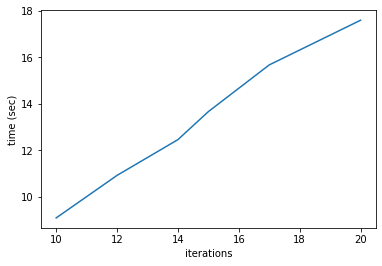

In [248]:
###### И относительно этих зафиксированных значений будем строить графики
# Проще всего - график для количества итераций (это просто с 210 по 215)
# Время обучения: 
plt.plot(iterations[210:216], time_spent[210:216])
plt.xlabel('iterations')
plt.ylabel('time (sec)')

Text(0, 0.5, 'train score')

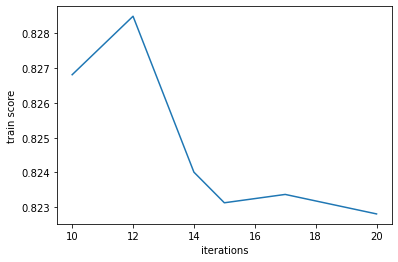

In [244]:
# Точность
plt.plot(iterations[210:216], train_scores[210:216])
# plt.plot(range(6), val_scores[210:216])
plt.xlabel('iterations')
plt.ylabel('train score')

Text(0, 0.5, 'val score')

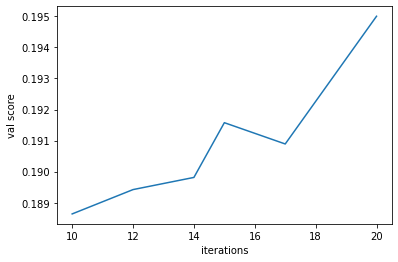

In [245]:
plt.plot(iterations[210:216], val_scores[210:216])
plt.xlabel('iterations')
plt.ylabel('val score')

In [ ]:
# Надо видимо дальше учить? Попробуем позже

In [201]:
# Ок. Теперь к остальным параметрам - lambda (при factors=70, iterations=20)
# Шаг для лямбды в массиве 48 (6 раз меняется итерация и 8 раз factors)
measures = []
for i in range(6):
    row = i * 48 + 23  # 23 - порядковый номер строки для измерений с factors=70
    measures.append({'lambda': lambdas[row], 'time': time_spent[row], 
                     'train': train_scores[row], 'val': val_scores[row], 'factors': factors[row]})

Text(0.5, 0, 'lambda')

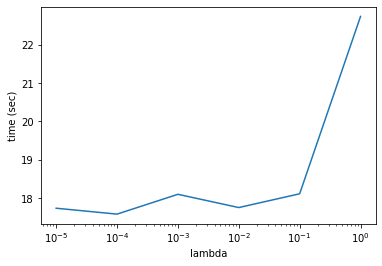

In [218]:
# Время
plt.plot(list(map(lambda x: x['lambda'], measures)), list(map(lambda x: x['time'], measures)))
plt.xscale('log') 
plt.ylabel('time (sec)')
plt.xlabel('lambda')

Text(0.5, 0, 'lambda')

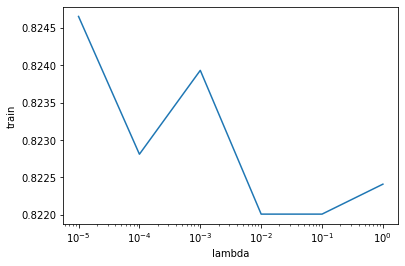

In [217]:
# Трейн скор
plt.plot(list(map(lambda x: x['lambda'], measures)), list(map(lambda x: x['train'], measures)))
plt.xscale('log') 
plt.ylabel('train')
plt.xlabel('lambda')

Text(0.5, 0, 'lambda')

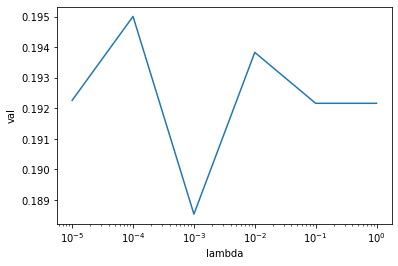

In [219]:
# Валидация
plt.plot(list(map(lambda x: x['lambda'], measures)), list(map(lambda x: x['val'], measures)))
plt.xscale('log') 
plt.ylabel('val')
plt.xlabel('lambda')

In [236]:
# Теперь количество факторов. Относительно lambda 0.0001, iterations 20
measures = []
for i in range(8):
    row = i * 6 + 197
    measures.append({'lambda': lambdas[row], 'time': time_spent[row], 'iterations': iterations[row],
                     'train': train_scores[row], 'val': val_scores[row], 'factors': factors[row]})

Text(0.5, 0, 'factors')

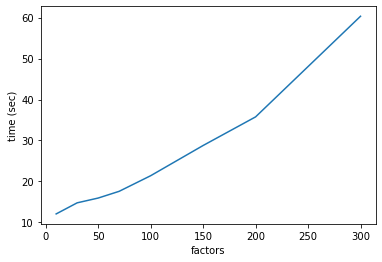

In [240]:
# Время
plt.plot(list(map(lambda x: x['factors'], measures)), list(map(lambda x: x['time'], measures)))
plt.ylabel('time (sec)')
plt.xlabel('factors')

Text(0.5, 0, 'factors')

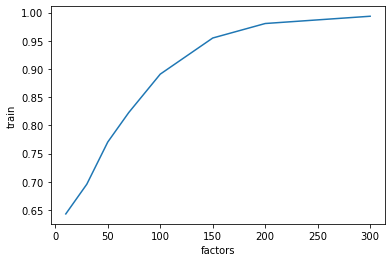

In [246]:
# Трейн скор
plt.plot(list(map(lambda x: x['factors'], measures)), list(map(lambda x: x['train'], measures)))
plt.ylabel('train')
plt.xlabel('factors')

Text(0.5, 0, 'factors')

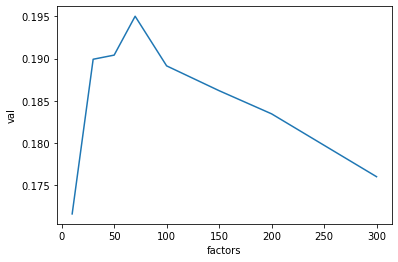

In [247]:
# Валидация
plt.plot(list(map(lambda x: x['factors'], measures)), list(map(lambda x: x['val'], measures)))
plt.ylabel('val')
plt.xlabel('factors')

In [ ]:
# Ну вобщем время - ожидаемо линейно зависит от количества итераций и от количества факторов. 
# От коэффициента регуляризации зависит не линейно, но тоже прослеживается...

In [ ]:
# Вот со скором все сложнее. Трейновый скор ожидаемо стабильно растет при уменьшении лямбды 
# и увеличении количества итераций - очевидно модель радостно переобучается. Количество латентных факторов тоже
# влияет на трейн-скор строго положительно (хоть и немного нелинейно)

# Валидационная точность - большое разочарование )) Пока не удалось дотянутья даже до максимального результата
# из предыдущего ДЗ.. (в прошлый раз мы уплотняли матрицу интеракций, отфильтровывая непопулярные товары до обучения)
# Сейчас мы работаем с полной (а соответственно более разреженной матрицей) - это еще один путь для поиска улучшений
# Но, кстати, график зависимости от количества итераций вселяет некую надежду. 
# Сейчас попробуем подольше поучить

In [251]:
train_scores = []
val_scores = []
for iters in range(1, 35):     

            model = evaluate_parms(0.0001, 70, iters)
            
            # Быстрый рекоменд (перемножение матриц из факторизации)
            fast_bm25_recs = model.user_factors @ model.item_factors.T
            
            # Вычисление скора по тесту
            result['fast_als_bm25'] = result['user_id'].apply(
                lambda x: v_to_item_id(np.argsort(fast_bm25_recs[userid_to_id[x]])[-5:]))
            val_score = v_precision_at_k(result.fast_als_bm25, result.actual).mean()
            val_scores.append(val_score)
            
            # По трейну
            train['fast_als_bm25'] = train['user_id'].apply(
                lambda x: v_to_item_id(np.argsort(fast_bm25_recs[userid_to_id[x]])[-5:]))
            train_score = v_precision_at_k(train.fast_als_bm25, train.actual).mean()
            train_scores.append(train_score)
            
            print('iterations {}, TRAIN_SCORE {:.5f}, VAL_SCORE {:.5f}'.
                  format(iters, train_score, val_score))

iterations 1, TRAIN_SCORE 0.78543, VAL_SCORE 0.14261
iterations 2, TRAIN_SCORE 0.79952, VAL_SCORE 0.17904
iterations 3, TRAIN_SCORE 0.81825, VAL_SCORE 0.18952
iterations 4, TRAIN_SCORE 0.82769, VAL_SCORE 0.18913
iterations 5, TRAIN_SCORE 0.82913, VAL_SCORE 0.18805
iterations 6, TRAIN_SCORE 0.83089, VAL_SCORE 0.18981
iterations 7, TRAIN_SCORE 0.82721, VAL_SCORE 0.19452
iterations 8, TRAIN_SCORE 0.82697, VAL_SCORE 0.19011
iterations 9, TRAIN_SCORE 0.83049, VAL_SCORE 0.19011
iterations 10, TRAIN_SCORE 0.82585, VAL_SCORE 0.18786
iterations 11, TRAIN_SCORE 0.82329, VAL_SCORE 0.19559
iterations 12, TRAIN_SCORE 0.82449, VAL_SCORE 0.18981
iterations 13, TRAIN_SCORE 0.82641, VAL_SCORE 0.19383
iterations 14, TRAIN_SCORE 0.82505, VAL_SCORE 0.19079
iterations 15, TRAIN_SCORE 0.82249, VAL_SCORE 0.18913
iterations 16, TRAIN_SCORE 0.82193, VAL_SCORE 0.19128
iterations 17, TRAIN_SCORE 0.82225, VAL_SCORE 0.19334
iterations 18, TRAIN_SCORE 0.82105, VAL_SCORE 0.19305
iterations 19, TRAIN_SCORE 0.82209, V

Text(0, 0.5, 'train score')

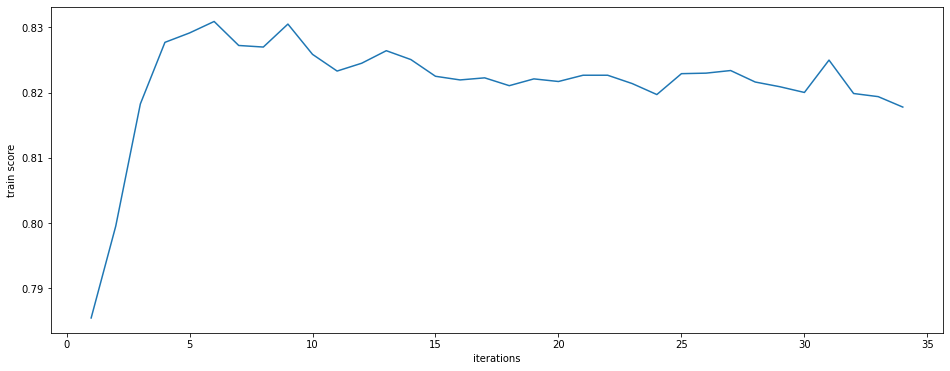

In [257]:
plt.figure(figsize=(16,6))
plt.plot(list(range(1, 35)), train_scores)
plt.xlabel('iterations')
plt.ylabel('train score')

Text(0, 0.5, 'val score')

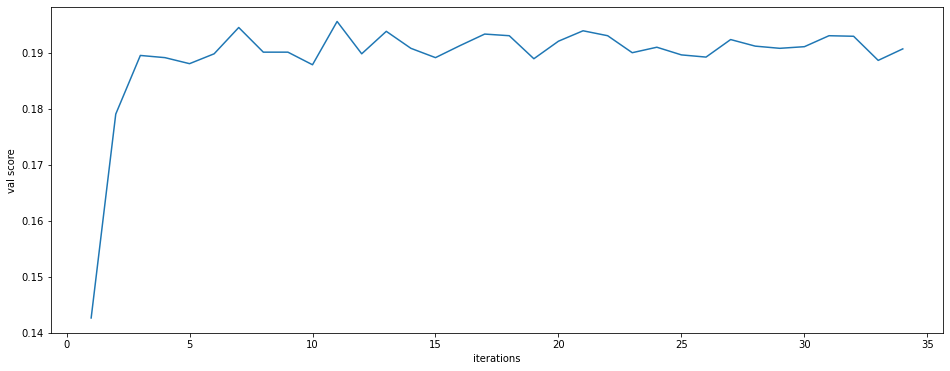

In [255]:
plt.figure(figsize=(16,6))
plt.plot(list(range(1, 35)), val_scores)
plt.xlabel('iterations')
plt.ylabel('val score')

In [256]:
# Но - нет ( 
# Показалось видимо...

In [345]:
# Вобщем пока на этом остановлюсь. Дальнейшие шаги - до-разобраться со взвешиванием, 
# подбор вариантов уплотнения матрицы

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!